# ANHIR: Evaluation Board

This notebook serves as visualisation for challenge results in several forms - standard tables and charts. First, all submissions have to be recomputed, so they also contain the detail about each image registration pair. One of the perspective to validate is the difference between training and testing.

The ANHIR challenge is hosted on https://anhir.grand-challenge.org.

These particular results are for ANHIR workshop hosted at ISBI 2019 in Venice, Italy.
In case you want to get some further evaluation related to new submission, you may contact one of the ANHIR administrators because the full submission is required, see https://anhir.grand-challenge.org/Organizers.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import glob, json
import shutil

import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path += [os.path.abspath('.'), os.path.abspath('..')]  # Add path to root
from birl.utilities.data_io import update_path
from birl.utilities.evaluate import compute_ranking
from birl.utilities.visualisation import RadarChart, draw_matrix_user_ranking
from bm_ANHIR.generate_regist_pairs import VAL_STATUS_TRAIN, VAL_STATUS_TEST
from bm_ANHIR.evaluate_submission import COL_TISSUE

This notebook serves for computing extended statistics (e.g. metrics inliding ranks) and visualie some more statistics.

In [2]:
# folder with all participants submissions
PATH_SUBMISSIONS = os.path.join(update_path('bm_ANHIR'), 'submissions')
# temporary folder for unzipping submissions
PATH_TEMP = os.path.abspath(os.path.expanduser('~/Desktop/ANHIR_submissions'))
# configuration needed for recomputing detail metrics
PATH_DATASET = os.path.join(update_path('bm_ANHIR'), 'dataset_ANHIR')
PATH_TABLE = os.path.join(PATH_DATASET, 'dataset_medium.csv')
PATH_LNDS_PROVIDED = os.path.join(PATH_DATASET, 'landmarks_all')
PATH_LNDS_COMPLATE = os.path.join(PATH_DATASET, 'landmarks_all')
PATH_COMP_BM = os.path.join(PATH_DATASET, 'computer-performances_cmpgrid-71.json')
FIELD_TISSUE = 'type-tissue'

## Parse and load submissions

All submissions are expected to be as a zip archives in single folder. The archive name is the author name.

In [3]:
# Find all archives and unzip them to the same folder.
archive_paths = sorted(glob.glob(os.path.join(PATH_SUBMISSIONS, '*.zip')))
submission_dirs = []

for path_zip in tqdm.tqdm(archive_paths, desc='unzipping'):
    sub = os.path.join(PATH_TEMP, os.path.splitext(os.path.basename(path_zip))[0])
    os.system('unzip %s -d %s' % (path_zip, sub))
    sub_ins = glob.glob(os.path.join(sub, '*'))
    # if the zip subfolder contain only one folder move it up
    if len(sub_ins) == 1:
        [shutil.move(p, sub) for p in glob.glob(os.path.join(sub_ins[0], '*'))]
    submission_dirs.append(sub)

unzipping: 100%|██████████| 12/12 [00:00<00:00, 68.78it/s]


Parse submissions and compute the final metrics. This can be computed just once.

In [ ]:
import bm_ANHIR.evaluate_submission

for path_sub in tqdm.tqdm(submission_dirs, desc='evaluation'):
    # run the evaluation with details
    path_json = bm_ANHIR.evaluate_submission.main(
        path_experiment=path_sub,
        path_cover=PATH_TABLE,
        path_dataset=PATH_LNDS_PROVIDED,
        path_reference=PATH_LNDS_COMPLATE,
        path_comp_bm=PATH_COMP_BM,
        path_output=path_sub,
        min_landmarks=1., details=True)
    # rename the metrics by the participant
    shutil.copy(os.path.join(path_sub, 'metrics.json'),
                os.path.join(PATH_SUBMISSIONS, os.path.basename(path_sub) + '.json'))

**Load parsed measures from each submission/experiment/participant.**

In [4]:
submission_paths = sorted(glob.glob(os.path.join(PATH_SUBMISSIONS, '*.json')))
submissions = {}
# loading all participants metrics
for path_sub in tqdm.tqdm(submission_paths, desc='loading'):
    with open(path_sub, 'r') as fp:
        metrics = json.load(fp)
    submissions[os.path.splitext(os.path.basename(path_sub))[0]] = metrics

print ('Users: %r' % submissions.keys())

loading: 100%|██████████| 12/12 [00:00<00:00, 104.36it/s]

Users: dict_keys(['HistoReg', 'Mohammed', 'RNiftyReg', 'bUnwarpJ', 'delamoer', 'lMW', 'masi', 'nick.weiss', 'pszma2', 'punithakumar', 'zhaoshuaibit', 'zsyzzsoft'])


In [5]:
# split the particular fields inside the measured items
users = list(submissions.keys())
print ('Fields: %r' % submissions[users[0]].keys())
user_aggreg = {u: submissions[u]['aggregates'] for u in users}
user_computer = {u: submissions[u]['computer'] for u in users}
user_cases = {u: submissions[u]['cases'] for u in users}
print ('required-landmarks: %r' % [submissions[u]['required-landmarks'] for u in users])
tissues = set(user_cases[users[0]][cs][FIELD_TISSUE] for cs in user_cases[users[0]])
print ('found tissues: %r' % sorted(tissues))

Fields: dict_keys(['aggregates', 'cases', 'computer', 'submission-time', 'required-landmarks'])
required-landmarks: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
found tissues: ['COAD', 'breast', 'gastric', 'kidney', 'lung-lesion', 'lung-lobes', 'mammary-gland', 'mice-kidney']


## Compute ranked measures

Extend the aggregated statistic by Rank measures such as compute ranking over all cases for each selected field and average it

In [6]:
for field, field_agg in [('rTRE-Median', 'Median-rTRE'),
                         ('rTRE-Max', 'Max-rTRE')]:
    user_cases = compute_ranking(user_cases, field)
    for user in users:
        for robust in [True, False]:  # iterate over Robust or all cases
            # chose inly robyst if it is required
            vals = [user_cases[user][cs][field + '_rank'] for cs in user_cases[user]
                    if (robust and user_cases[user][cs]['Robustness']) or (not robust)]
            s_robust = '-Robust' if robust else ''
            user_aggreg[user]['Average-Rank-' + field_agg + s_robust] = np.mean(vals)
        for tissue in tissues:
            vals = [user_cases[user][cs][field + '_rank'] for cs in user_cases[user]
                    if user_cases[user][cs][FIELD_TISSUE] == tissue]
            user_aggreg[user]['Average-Rank-' + field_agg + '_tissue_' + tissue] = np.mean(vals)

Show the raw table with global statiscit (joint training and testing/evalaution).

In [7]:
cols_general = [col for col in pd.DataFrame(user_aggreg).T.columns 
                if not any(n in col for n in [VAL_STATUS_TRAIN, VAL_STATUS_TEST, '_tissue_'])]
pd.set_option("display.max_columns", 25)
pd.DataFrame(user_aggreg).T.sort_values('Average-Median-rTRE')[cols_general]

,Average-Average-rTRE,Average-Average-rTRE-Robust,Average-Max-rTRE,Average-Max-rTRE-Robust,Average-Median-rTRE,Average-Median-rTRE-Robust,Average-Norm-Time,Average-Norm-Time-Robust,Average-Rank-Max-rTRE,Average-Rank-Max-rTRE-Robust,Average-Rank-Median-rTRE,Average-Rank-Median-rTRE-Robust,Average-Robustness,Average-used-landmarks,Median-Average-rTRE,Median-Average-rTRE-Robust,Median-Max-rTRE,Median-Max-rTRE-Robust,Median-Median-rTRE,Median-Median-rTRE-Robust,Median-Norm-Time,Median-Norm-Time-Robust
HistoReg,0.004057,0.004057,0.023043,0.023043,0.002790,0.002790,1.451193,1.451193,4.074844,4.074844,3.374220,3.374220,1.000000,1.025198,0.003009,0.003009,0.017465,0.017465,0.001918,0.001918,1.374846,1.374846
zhaoshuaibit,0.004664,0.004656,0.022607,0.022592,0.003476,0.003471,6.098517,6.106647,4.958420,4.947917,5.634096,5.627083,0.997921,1.026104,0.003490,0.003487,0.017278,0.017215,0.002565,0.002553,4.824366,4.825087
lMW,0.005637,0.005611,0.030005,0.029932,0.003805,0.003777,6.863679,6.860032,5.945946,5.933333,3.690229,3.672917,0.997921,1.025250,0.003395,0.003381,0.023059,0.023048,0.001973,0.001968,5.791019,5.787261
nick.weiss,0.005192,0.004321,0.026069,0.024423,0.003853,0.002924,0.145392,0.145501,4.773389,4.758333,3.106029,3.087500,0.997921,1.025250,0.002889,0.002888,0.018566,0.018537,0.001818,0.001817,0.141754,0.141826
zsyzzsoft,0.004742,0.003550,0.014927,0.013330,0.004102,0.002893,0.000705,0.000706,2.484407,2.464583,2.839917,2.820833,0.997921,1.025250,0.001203,0.001169,0.004634,0.004472,0.001021,0.001016,0.000510,0.000510
delamoer,0.006054,0.005845,0.026128,0.025781,0.004614,0.004393,7.127142,7.155800,5.621622,5.581590,5.993763,5.956067,0.993763,1.025356,0.004653,0.004643,0.020775,0.020765,0.003320,0.003314,7.488842,7.508170
masi,0.010364,0.007184,0.038723,0.033379,0.008724,0.005648,9.628429,9.131541,6.199584,5.699541,6.097713,5.536697,0.937634,1.027798,0.003719,0.003350,0.023399,0.020732,0.002501,0.002225,NaN,8.767961
pszma2,0.024733,0.018768,0.075656,0.064163,0.020720,0.015234,2.521503,2.534813,9.704782,9.600442,10.228690,10.152318,0.955696,1.029272,0.010619,0.010075,0.044584,0.043188,0.008023,0.007609,NaN,2.340179
Mohammed,0.025152,0.018417,0.074940,0.062738,0.021255,0.014963,2.540539,2.549469,8.397089,8.511161,8.923077,9.073661,0.959315,1.029598,0.010619,0.010014,0.044209,0.042897,0.008053,0.007528,NaN,2.352564
punithakumar,0.057025,0.017150,0.119045,0.047263,0.055125,0.015539,1.470925,1.461005,8.478170,7.914216,9.692308,9.303922,0.848233,1.034828,0.010979,0.009077,0.035972,0.031888,0.009043,0.007355,1.367489,1.371322


Show separatlyraw table with statistic for tran and tes cases separatly.

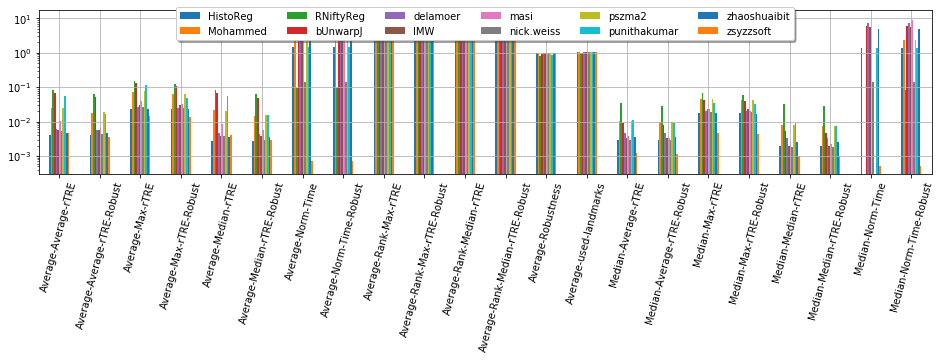

In [8]:
ax = pd.DataFrame(user_aggreg).T[cols_general].T.plot.bar(figsize=(16, 3), grid=True, logy=True, rot=75)
_= ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=int(len(users) / 2), fancybox=True, shadow=True)

## Compare statistic "train" vs "test"

Compute sts. on training and testing case also foor newly add rank measures.

In [9]:
for field, field_agg in [# ('rTRE-Median', 'Median-rTRE'),
                         ('rTRE-Median_rank', 'Rank-Median-rTRE'),
                         # ('rTRE-Max', 'Max-rTRE'),
                         ('rTRE-Max_rank', 'Rank-Max-rTRE'),
                         ('Norm-Time_minutes', 'Norm-Time')]:
    for user in users:
        for state in [VAL_STATUS_TRAIN, VAL_STATUS_TEST]:
            vals = [user_cases[user][cs][field] for cs in user_cases[user]
                    if user_cases[user][cs]['Status'] == state]
            user_aggreg[user]['Average-' + field_agg + '_' + state] = np.nanmean(vals)

Display just raw table with results.

In [10]:
df = pd.DataFrame(user_aggreg).T
cols_train_test = [col for col in df.columns if any(st in col for st in [VAL_STATUS_TRAIN, VAL_STATUS_TEST])]
df.sort_values('Average-Median-rTRE')[cols_train_test].to_csv('stat-results_train-test.csv')

In [11]:
from IPython.display import display
for state in [VAL_STATUS_TRAIN, VAL_STATUS_TEST]:
    df = pd.DataFrame(user_aggreg).T
    cols = [col for col in df.columns if state in col]
    display(df.sort_values('Average-Rank-Median-rTRE_evaluation')[cols])

,Average-Average-rTRE_training,Average-Max-rTRE_training,Average-Median-rTRE_training,Average-Norm-Time_training,Average-Rank-Max-rTRE_training,Average-Rank-Median-rTRE_training,Average-Robustness_training,Median-Average-rTRE_training,Median-Max-rTRE_training,Median-Median-rTRE_training,Median-Robustness_training
nick.weiss,0.006096,0.027120,0.004924,0.122241,4.669565,3.313043,0.995652,0.002964,0.018286,0.001857,1.0
HistoReg,0.003902,0.022146,0.002717,1.293520,4.082609,3.426087,1.000000,0.003058,0.016792,0.001948,1.0
lMW,0.006021,0.031823,0.004042,7.208083,6.265217,3.926087,1.000000,0.003656,0.023500,0.002023,1.0
delamoer,0.007955,0.028522,0.006701,6.397704,6.269565,7.917391,0.986957,0.006027,0.022732,0.005048,1.0
zsyzzsoft,0.000132,0.000630,0.000111,0.000510,1.095652,1.082609,1.000000,0.000124,0.000450,0.000106,1.0
masi,0.014693,0.049695,0.013028,9.514249,6.852174,6.921739,0.869159,0.005126,0.027064,0.003106,NaN
zhaoshuaibit,0.003811,0.020166,0.002733,4.922491,4.691304,4.826087,1.000000,0.003421,0.016496,0.002447,1.0
bUnwarpJ,0.036243,0.085343,0.034088,5.914753,8.073913,7.978261,0.939130,0.010063,0.045554,0.005869,1.0
Mohammed,0.020402,0.068639,0.016701,2.332056,8.304348,8.708696,0.968468,0.011298,0.045754,0.008213,NaN
punithakumar,0.060474,0.126252,0.059492,1.216498,8.491304,9.652174,0.847826,0.011664,0.037880,0.009985,1.0


,Average-Average-rTRE_evaluation,Average-Max-rTRE_evaluation,Average-Median-rTRE_evaluation,Average-Norm-Time_evaluation,Average-Rank-Max-rTRE_evaluation,Average-Rank-Median-rTRE_evaluation,Average-Robustness_evaluation,Median-Average-rTRE_evaluation,Median-Max-rTRE_evaluation,Median-Median-rTRE_evaluation,Median-Robustness_evaluation
nick.weiss,0.004363,0.025107,0.002871,0.166606,4.868526,2.916335,1.000000,0.002740,0.018827,0.001804,1.0
HistoReg,0.004198,0.023865,0.002858,1.595675,4.067729,3.326693,1.000000,0.002897,0.019016,0.001899,1.0
lMW,0.005286,0.028339,0.003588,6.548090,5.653386,3.474104,0.996016,0.003220,0.022489,0.001913,1.0
delamoer,0.004312,0.023934,0.002702,7.795553,5.027888,4.231076,1.000000,0.003235,0.018857,0.002267,1.0
zsyzzsoft,0.008966,0.028027,0.007759,0.000884,3.756972,4.450199,0.996016,0.002902,0.017783,0.002071,1.0
masi,0.006397,0.028668,0.004780,9.725777,5.601594,5.342629,0.996016,0.003128,0.020421,0.002059,1.0
zhaoshuaibit,0.005446,0.024843,0.004157,7.176150,5.203187,6.374502,0.996016,0.003724,0.019671,0.002646,1.0
bUnwarpJ,0.097328,0.181180,0.097233,7.224828,7.601594,8.187251,0.920319,0.008032,0.038716,0.005398,1.0
Mohammed,0.029505,0.080714,0.025428,2.729450,8.482072,9.119522,0.951020,0.010200,0.041996,0.007991,NaN
punithakumar,0.053866,0.112441,0.051124,1.704066,8.466135,9.729084,0.848606,0.010020,0.035309,0.008247,1.0


Transform the case format data to be simple form with extra colums for used and case ID to be able to draw a violine plot later.

In [12]:
dfs_cases = []
for usr in users:
    df = pd.DataFrame(user_cases[usr]).T
    df['user'] = usr
    df['case'] = df.index
    dfs_cases.append(df)
df_cases = pd.concat(dfs_cases).reset_index()

for col in df_cases.columns:
    try: df_cases[col] = pd.to_numeric(df_cases[col])
    except Exception: pass
# df_cases.head()

### Showing several violine plots

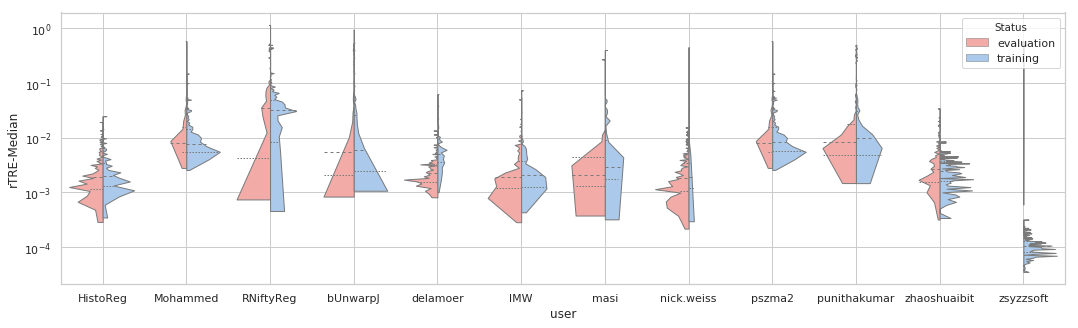

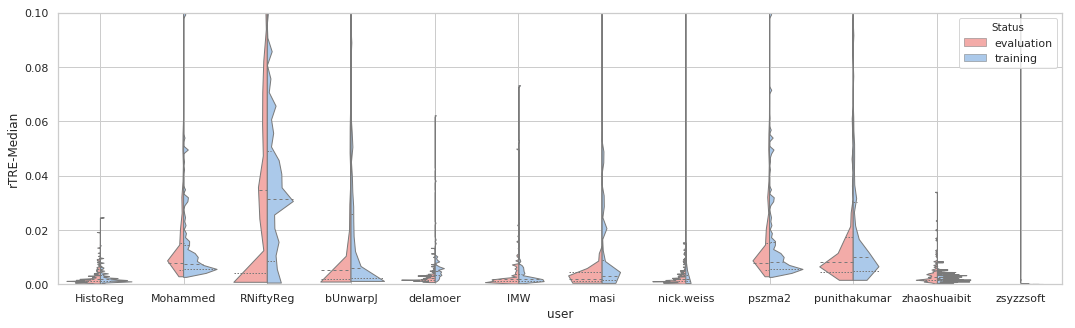

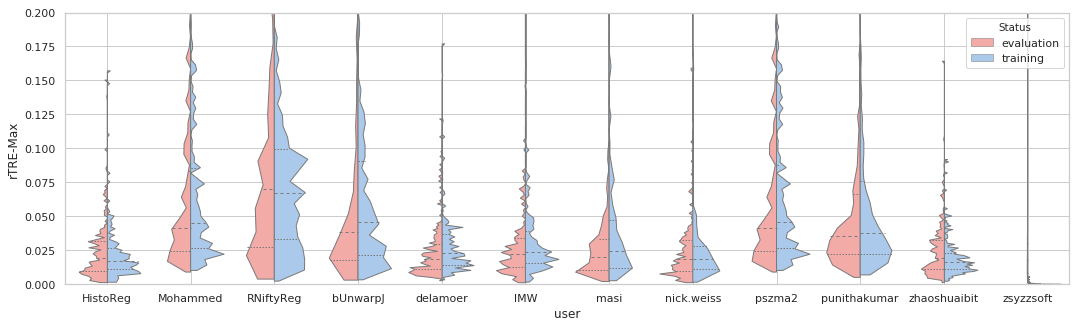

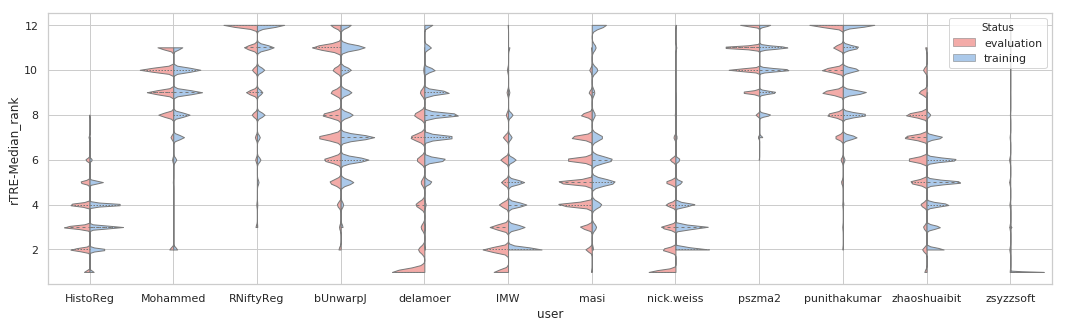

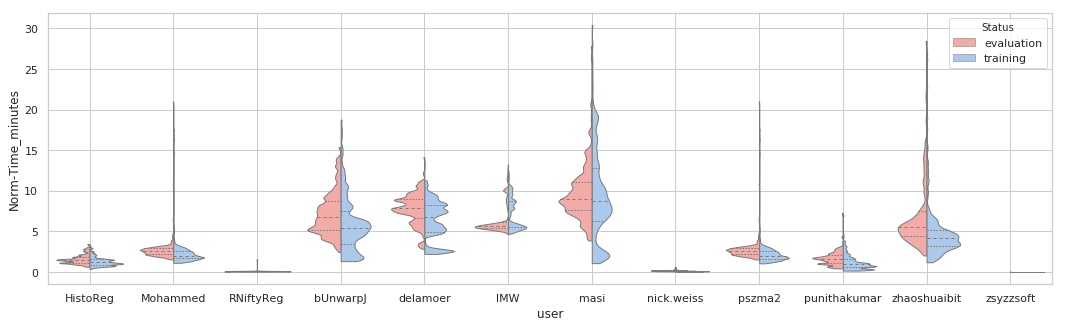

In [13]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
for field, log, vmax, bw in [('rTRE-Median', True, None, 0.01),
                             ('rTRE-Median', False, 0.1, 0.01),
                             ('rTRE-Max', False, 0.2, 0.02),
                             ('rTRE-Median_rank', False, None, 0.05),
                             ('Norm-Time_minutes', False, None, 0.1)]:
    fig, ax = plt.subplots(figsize=(18, 5))
    sns.violinplot(ax=ax, data=df_cases, x='user', hue='Status', y=field,
                   cut=0, split=True, bw=bw, scale='area', scale_hue=True, inner='quartile',
                   palette={"evaluation": "r", "training": "b"}, linewidth=1., rot=60)
    if log:
        ax.set_yscale('log')
    if vmax:
        ax.set_ylim([0, vmax])
    ax.grid(True)

## Visualise global results

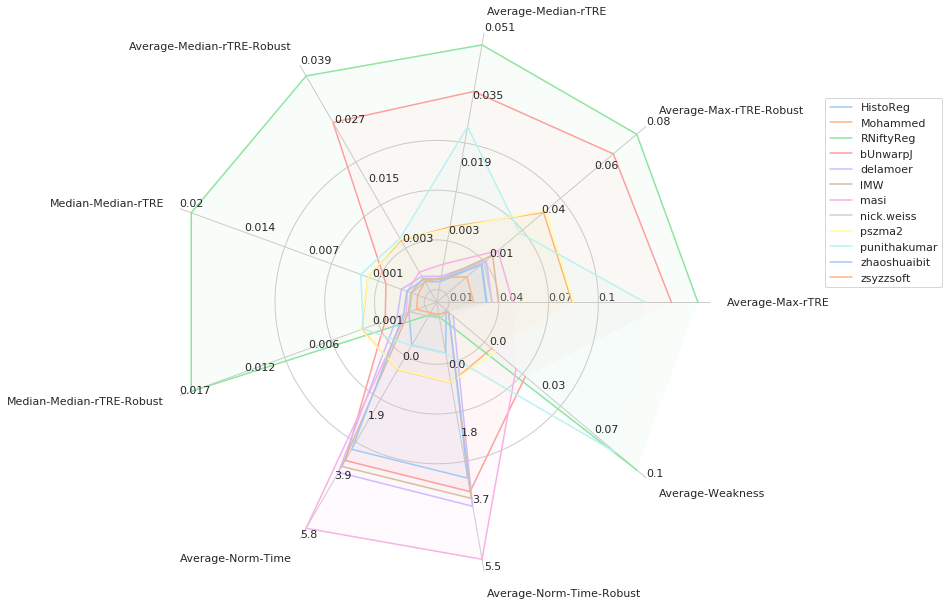

In [14]:
fields = ['Average-Max-rTRE', 'Average-Max-rTRE-Robust',
          'Average-Median-rTRE', 'Average-Median-rTRE-Robust',
          'Median-Median-rTRE', 'Median-Median-rTRE-Robust',
          # 'Average-Rank-Max-rTRE', 'Average-Rank-Median-rTRE',
          'Average-Norm-Time', 'Average-Norm-Time-Robust',
          'Average-Robustness',]
df = pd.DataFrame(user_aggreg).T[fields]
df['Average-Weakness'] = 1 - df['Average-Robustness']
del df['Average-Robustness']

radar = RadarChart(df, fig=plt.figure(figsize=(12, 8)))

## Visualise partial rankings

With given metrics compute ranking among all participants, so each user has a unique colour and then the users are sorted in ascending order...

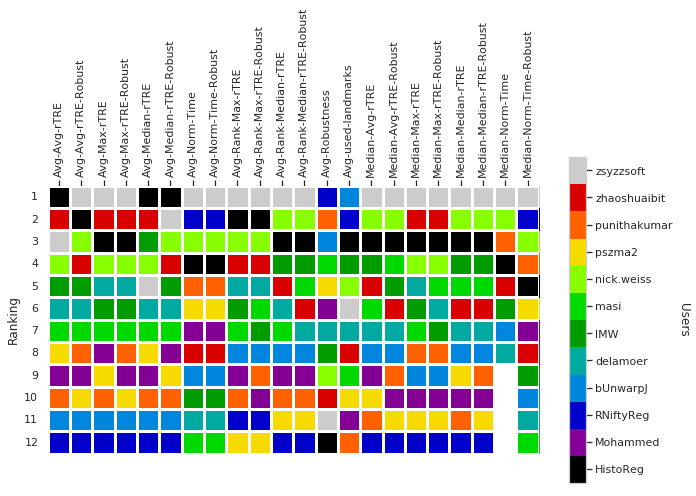

In [32]:
dfx = pd.DataFrame(user_aggreg).T[cols_general]
dfx.columns = [c.replace('Average', 'Avg') for c in dfx.columns]
fig = draw_matrix_user_ranking(dfx)

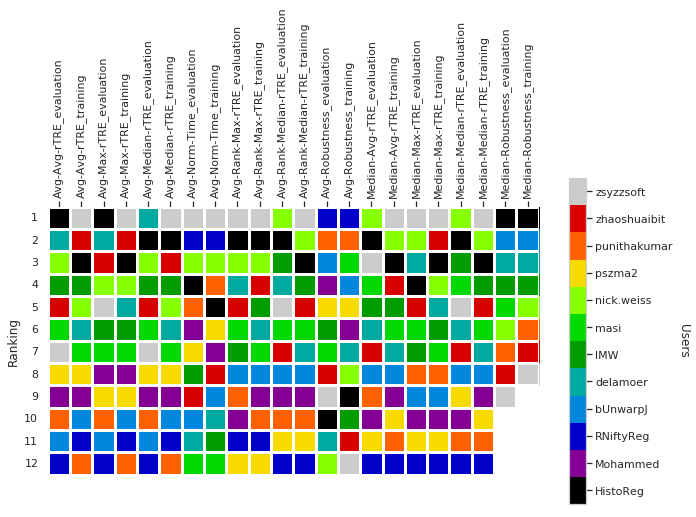

In [33]:
dfx = pd.DataFrame(user_aggreg).T[cols_train_test]
dfx.columns = [c.replace('Average', 'Avg') for c in dfx.columns]
fig = draw_matrix_user_ranking(dfx)

## Visual statistic over tissue types

Present some statistis depending on the tissue types...

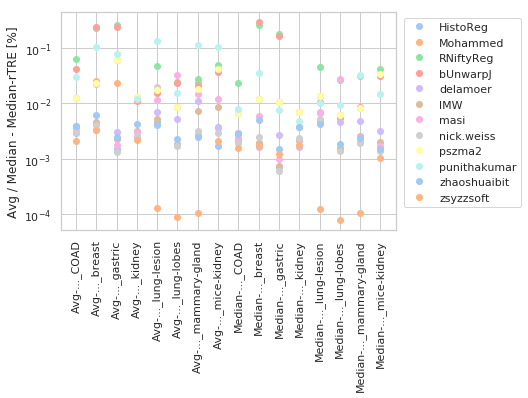

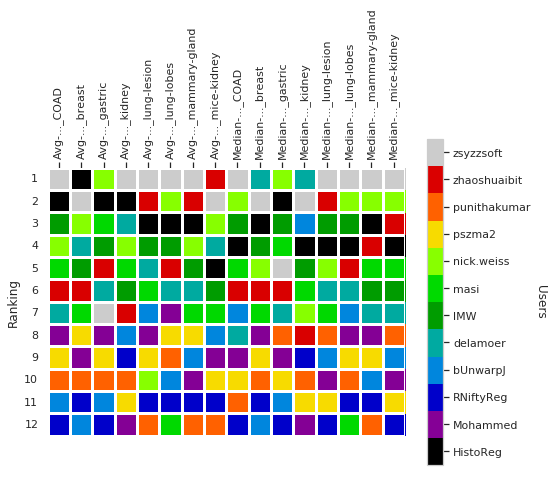

In [36]:
col_avg_med_tissue = [c for c in pd.DataFrame(user_aggreg).T.columns
                      if 'Median-rTRE_tissue' in c and not 'Rank' in c]
dfx = pd.DataFrame(user_aggreg).T[col_avg_med_tissue]
dfx.T.plot(style='o', cmap='nipy_spectral', figsize=(len(dfx) / 2, 4), grid=True)
_= plt.legend(loc='upper center', bbox_to_anchor=(1.2, 1.0), ncol=1)
_= plt.xticks(range(len(col_avg_med_tissue)),
              [c.replace('Median-rTRE_tissue', '...').replace('Average', 'Avg') for c in col_avg_med_tissue],
              rotation=90)
_= plt.yscale('log'), plt.ylabel('Avg / Median - Median-rTRE [%]')

dfx.columns = [c.replace('Median-rTRE_tissue', '...').replace('Average', 'Avg') for c in dfx.columns]
fig = draw_matrix_user_ranking(dfx)

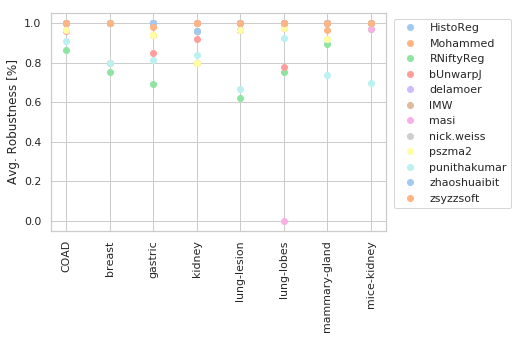

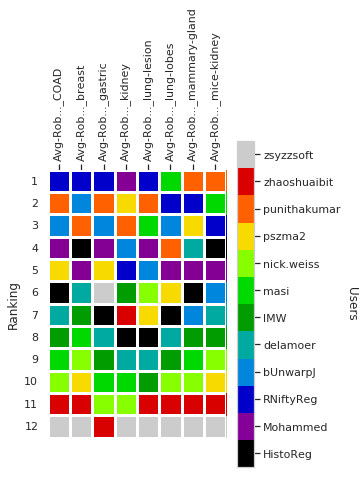

In [35]:
col_robust_tissue = [c for c in pd.DataFrame(user_aggreg).T.columns
                      if 'Average-Robustness_tissue' in c and not 'Rank' in c]
dfx = pd.DataFrame(user_aggreg).T[col_robust_tissue]
dfx.T.plot(style='o', cmap='nipy_spectral', figsize=(len(dfx) / 2, 4), grid=True)
_= plt.legend(loc='upper center', bbox_to_anchor=(1.2, 1.0), ncol=1)
_= plt.xticks(range(len(col_robust_tissue)),
              [c.replace('Average-Robustness_tissue_', '') for c in col_robust_tissue],
              rotation=90)
_= plt.ylabel('Avg. Robustness [%]')

dfx.columns = [c.replace('Average-Robustness_tissue', 'Avg-Rob...') for c in dfx.columns]
fig = draw_matrix_user_ranking(dfx)